C:\python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


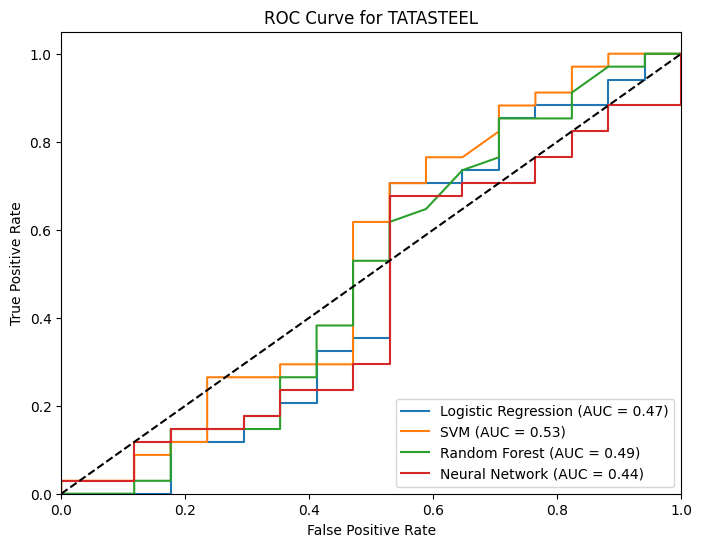

Results for TATASTEEL
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.627451   0.632997  0.627451  0.629993  0.470588
SVM                  0.666667   0.620567  0.666667  0.590241  0.531142
Random Forest        0.607843   0.584345  0.607843  0.592593  0.490484
Neural Network       0.549020   0.580982  0.549020  0.560033  0.442907
                     Sharpe Ratio  Maximum Drawdown  Number of Trades  \
Logistic Regression     -0.140111          0.175001              50.0   
SVM                      0.005739          0.101318              50.0   
Random Forest            0.050097          0.096995              51.0   
Neural Network          -0.025044          0.086244              50.0   

                     Win Ratio  
Logistic Regression    0.34000  
SVM                    0.52000  
Random Forest          0.45098  
Neural Network         0.32000  


C:\python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


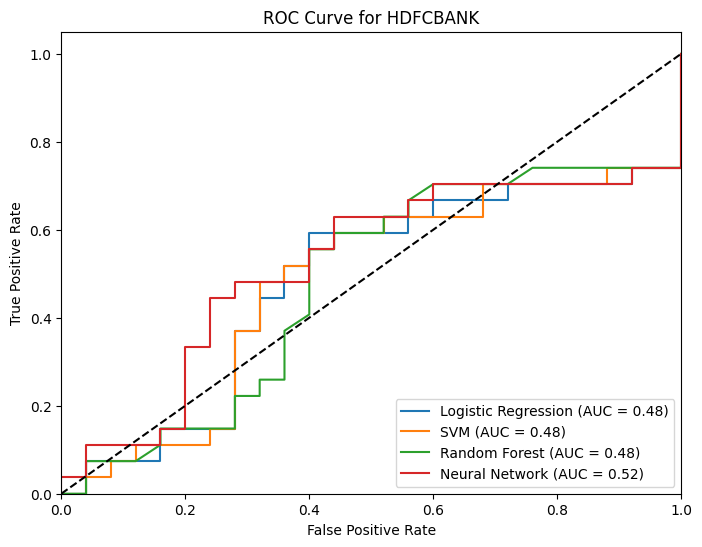

Results for HDFCBANK
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.480769   0.465659  0.480769  0.451479  0.480000
SVM                  0.403846   0.296110  0.403846  0.321662  0.478519
Random Forest        0.442308   0.391484  0.442308  0.383421  0.475556
Neural Network       0.576923   0.576116  0.576923  0.575664  0.518519
                     Sharpe Ratio  Maximum Drawdown  Number of Trades  \
Logistic Regression      0.114538          0.061423              51.0   
SVM                      0.105207          0.080172              51.0   
Random Forest            0.063708          0.077795              51.0   
Neural Network           0.128951          0.059696              52.0   

                     Win Ratio  
Logistic Regression   0.450980  
SVM                   0.509804  
Random Forest         0.470588  
Neural Network        0.365385  


C:\python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


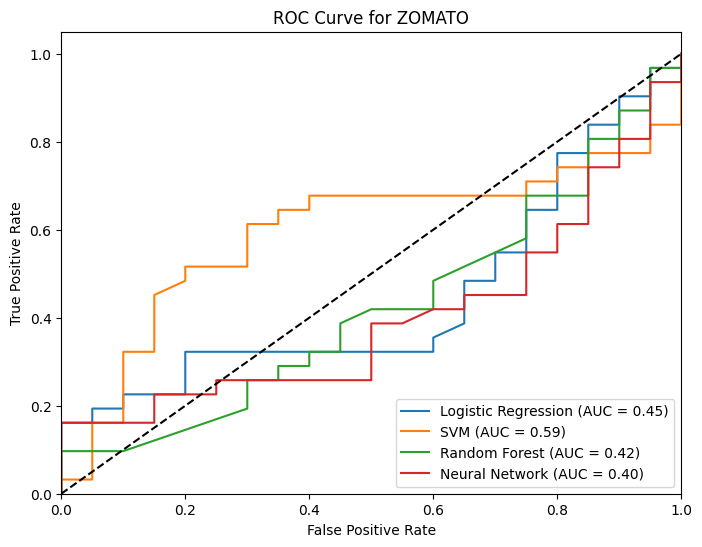

Results for ZOMATO
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.607843   0.568227  0.607843  0.491533  0.445968
SVM                  0.588235   0.364706  0.588235  0.450254  0.592742
Random Forest        0.568627   0.460159  0.568627  0.469080  0.424194
Neural Network       0.431373   0.399237  0.431373  0.411974  0.399194
                     Sharpe Ratio  Maximum Drawdown  Number of Trades  \
Logistic Regression      0.119649          0.168436              50.0   
SVM                      0.095695          0.164330              50.0   
Random Forest            0.119097          0.146043              50.0   
Neural Network           0.205815          0.078973              50.0   

                     Win Ratio  
Logistic Regression       0.50  
SVM                       0.50  
Random Forest             0.48  
Neural Network            0.42  
Best model is SVM with ROC AUC: 0.59


In [9]:
#Importing all relevent libraries 

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import pickle

# IfNeeded
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# Function to preprocess and clean the textual data
def processing_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Function to get price movement
def price_movement(stock_data, index, time_horizon=1):
    if index + time_horizon < len(stock_data):
        price_change = stock_data.iloc[index + time_horizon]['Close'] - stock_data.iloc[index]['Close']
        if price_change > 0:
            return 1  # Increase
        elif price_change < 0:
            return -1  # Decrease
    return 0  # No change

# Function to calculate trading metrics
def calculate_trading_metrics(model, X, stock_data):
    predictions = model.predict(X)
    stock_data = stock_data.iloc[-len(predictions):]  # Align stock_data with predictions
    returns = pd.Series(np.where(predictions == 1, stock_data['Close'].pct_change().shift(-1), 0))
    returns.index = stock_data.index
    returns = returns.dropna()
    Myvalue = (returns + 1).cumprod()
    sharperatio = np.mean(returns) / np.std(returns)
    maxdrawdown = np.max(np.maximum.accumulate(Myvalue) - Myvalue)
    numbertrades = len(returns)
    winratio = np.sum(returns > 0) / numbertrades
    return {
        'Sharpe Ratio': sharperatio,
        'Maximum Drawdown': maxdrawdown,
        'Number of Trades': numbertrades,
        'Win Ratio': winratio
    }

# Load news data
news_data = pd.read_csv('news_headlines_with_labels_updated_ekdumfinal_without_label.csv')
news_data['processed_headline'] = news_data['News Headlines'].apply(processing_text)

# Load stock data
stock_files = {
    'TATASTEEL': 'TATASTEEL.NS.csv',
    'HDFCBANK': 'HDFCBANK.NS.csv',  
    'ZOMATO': 'ZOMATO.NS.csv'
}
results_summary = {}
trading_metrics_summary = {}

best_model_name = ''
best_model = None
best_roc_auc = 0.0

# Loop through each stock
for stock_name, stock_file in stock_files.items():
    stock_data = pd.read_csv(stock_file)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    min_length = min(len(stock_data), len(news_data))
    stock_data = stock_data.head(min_length)
    news_data_truncated = news_data.head(min_length).copy()
    news_data_truncated['label'] = [price_movement(stock_data, i) for i in range(len(news_data_truncated))]
    news_data_truncated = news_data_truncated[news_data_truncated['label'] != 0]
    
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(news_data_truncated['processed_headline']).toarray()
    y = news_data_truncated['label'].values  # Ensure y is a 1D array

    # Save the vectorizer
    with open(f'{stock_name}_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=300, multi_class='ovr'),
        'SVM': SVC(probability=True),
        'Random Forest': RandomForestClassifier(),
        'Neural Network': MLPClassifier(max_iter=300)
    }

    results = {}
    roc_curves = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        # Save each model
        with open(f'{stock_name}_{model_name.replace(" ", "_")}.pkl', 'wb') as f:
            pickle.dump(model, f)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else np.zeros_like(y_pred)
        if y_proba.ndim == 1 or y_proba.shape[1] == 1:                                                        # Handle single-column case
            y_proba = np.column_stack([1 - y_proba, y_proba])
        results[model_name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1 Score': f1_score(y_test, y_pred, average='weighted'),
            'ROC AUC': roc_auc_score(y_test, y_proba[:, 1])
        }
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_curves[model_name] = (fpr, tpr, auc(fpr, tpr))

        # Update the best model based on ROC AUC
        
        if results[model_name]['ROC AUC'] > best_roc_auc:
            best_roc_auc = results[model_name]['ROC AUC']
            best_model_name = model_name
            best_model = model

    results_df = pd.DataFrame(results).T
    results_summary[stock_name] = results_df
    trading_metrics = {}

    for model_name, model in models.items():
        trading_metrics[model_name] = calculate_trading_metrics(model, X_test, stock_data)
    trading_metrics_df = pd.DataFrame(trading_metrics).T
    trading_metrics_summary[stock_name] = trading_metrics_df

    # Plot ROC curves

    
    plt.figure(figsize=(8, 6))
    for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {stock_name}')
    plt.legend(loc='lower right')
    plt.show()

    # Print results

    
    print(f'Results for {stock_name}')
    print(results_df)
    print(trading_metrics_df)

# Print the best model
print(f'Best model is {best_model_name} with ROC AUC: {best_roc_auc:.2f}')



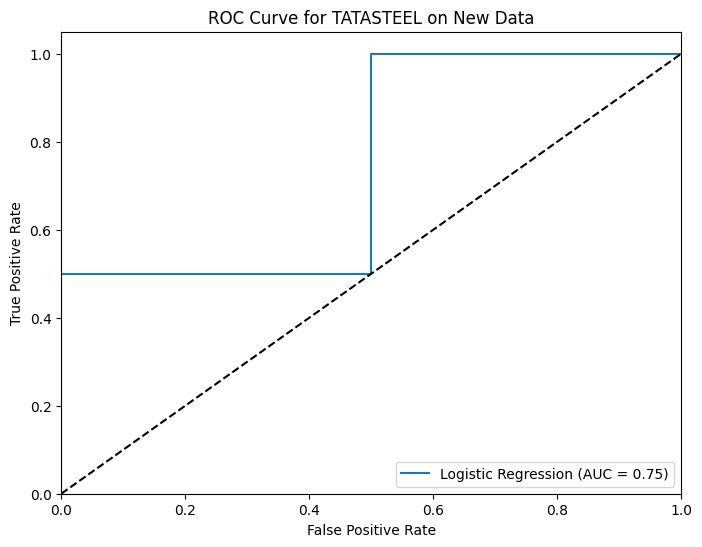

Evaluation Metrics:
{'Accuracy': 0.8333333333333334, 'Precision': 0.8666666666666667, 'Recall': 0.8333333333333334, 'F1 Score': 0.8148148148148148, 'ROC AUC': 0.75}
Trading Metrics:
{'Sharpe Ratio': -0.03799060814050236, 'Maximum Drawdown': 0.011195053094412932, 'Number of Trades': 5, 'Win Ratio': 0.6}


In [8]:
  def predict_and_evaluate_new_data(new_news_file, new_stock_file, stock_name, best_model_name):
    # Load new news data and preprocess
      
    new_news_data = pd.read_csv(new_news_file)
    new_news_data['processed_headline'] = new_news_data['News Headlines'].apply(processing_text)

    # Load new stock data
    new_stock_data = pd.read_csv(new_stock_file)
    new_stock_data['Date'] = pd.to_datetime(new_stock_data['Date'])
    min_length = min(len(new_stock_data), len(new_news_data))
    new_stock_data = new_stock_data.head(min_length)
    new_news_data_truncated = new_news_data.head(min_length).copy()
    new_news_data_truncated['label'] = [price_movement(new_stock_data, i) for i in range(len(new_news_data_truncated))]
    new_news_data_truncated = new_news_data_truncated[new_news_data_truncated['label'] != 0]

    # Load the vectorizer and transform the new news data
    with open(f'{stock_name}_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    X_new = vectorizer.transform(new_news_data_truncated['processed_headline']).toarray()
    y_new = new_news_data_truncated['label'].values  # Ensure y_new is a 1D array

    # Load the best model
    with open(f'{stock_name}_{best_model_name.replace(" ", "_")}.pkl', 'rb') as f:
        best_model = pickle.load(f)
    
    # Predict with probabilities if the model supports it
    y_new_pred = best_model.predict(X_new)
    y_new_proba = best_model.predict_proba(X_new)[:, 1] if hasattr(best_model, 'predict_proba') else np.zeros_like(y_new_pred)

    # Evaluate the model
    evaluation_metrics = {
        'Accuracy': accuracy_score(y_new, y_new_pred),
        'Precision': precision_score(y_new, y_new_pred, average='weighted'),
        'Recall': recall_score(y_new, y_new_pred, average='weighted'),
        'F1 Score': f1_score(y_new, y_new_pred, average='weighted'),
        'ROC AUC': roc_auc_score(y_new, y_new_proba)
    }

    # Calculate trading metrics
    trading_metrics = calculate_trading_metrics(best_model, X_new, new_stock_data)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_new, y_new_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {evaluation_metrics["ROC AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {stock_name} on New Data')
    plt.legend(loc='lower right')
    plt.show()

    return evaluation_metrics, trading_metrics

# Example usage
new_news_file = 'News Headlines_for _tata_steel_new-1.csv'  # Replace with the new news headlines CSV file path
new_stock_file = 'TATASTEEL.NS (1).csv'  # Replace with the new stock data CSV file path
stock_name = 'TATASTEEL'
best_model_name = 'Logistic Regression'  # Replace with the best model name used during training

evaluation_metrics, trading_metrics = predict_and_evaluate_new_data(new_news_file, new_stock_file, stock_name, best_model_name)

# Print evaluation metrics and trading metrics
print('Evaluation Metrics:')
print(evaluation_metrics)
print('Trading Metrics:')
print(trading_metrics)
